In [1]:
import os,sys
sys.path.append('./hmvec-master/')
import hmvec as hm # Git clone and pip install as in readme from github.com/msyriac/hmvec
from compute_power_spectra import *
from params import *
from plotting import *

np_load_old = np.load
np.load     = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [2]:
ellMax = 9600
ells = np.arange(ellMax)

getgas = True
dictKey = dictKey_NFW
model = modelParams_NFW
rscale = True

cych = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

baseline = ghztoev(30)

ztype = [2., 6., 10.]
zreio = 6.
nZs = 50

compute_noise = False
compute_BB_noise = False

fsky = [0.7, 0.5, 0.5]


In [3]:
maind = 14
MA = dictKey_NFW[maind]
zMin, zMax, rMin, rMax = chooseModel(MA, model)

ztest =6.
zMax = min(ztest, zMax)

data = import_data(MA, nZs, zMin, zMax, ellMax, getgas=False, rscale=True)

rcross, prob, avtau, dtaudz, rcrossMW, probMW, uell0, Cell1H, Cell2H, CMBDP, CMBDP2 = data

taubar = 4*np.pi * avtau/baseline
taubarwithMW = (avtau + probMW)/baseline


In [4]:
if True:
    ms  = np.geomspace(1e11,1e17,100)       # masses
    zs  = np.linspace(zMin,zMax,nZs)        # redshifts
    ks  = np.geomspace(1e-4,1e3,1001)       # wavenumbers

    # Halo Model
    hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')
    #gas = hcos.add_battaglia_profile("y", family="AGN", xmax=2, nxs=30000)

    chis   = hcos.comoving_radial_distance(zs)
    rvirs  = np.asarray([hcos.rvir(ms,zz) for zz in zs])
    cs     = hcos.concentration()
    Hz     = hcos.h_of_z(zs)
    nzm    = hcos.get_nzm()
    biases = hcos.get_bh()
    deltav = hcos.deltav(zs)
    rhocritz = hcos.rho_critical_z(zs)
    dvols = get_volume_conv(chis, Hz)



In [5]:
gas = hcos.add_battaglia_profile("y",family="AGN",xmax=2,nxs=30000)

/home/dpirvu/DarkPhoton/./hmvec-master/hmvec/fft.py:90: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [6]:
rs  = np.linspace(rMin, rMax, 100000)              # halo radius


In [7]:
# Choose one single halo for the analysis below
zsindex = 17
msindex = 17

m200critz, r200critz = get_200critz(zs, ms, cs, rhocritz, deltav)

# rss is the fit parameter in the NFW profile function r_s
# which is the location of the turning point in the NFW density profile
rss = (rvirs[zsindex,msindex]/cs[zsindex,msindex])

nfw_rhoscsale = hm.rhoscale_nfw(ms[msindex], rvirs[zsindex,msindex], cs[zsindex,msindex])

nfw_profile = hm.rho_nfw(rs, nfw_rhoscsale, rss)

gas_profile = hm.rho_gas(rs, m200critz[zsindex,msindex], zs[zsindex], 1., 1., rhocritz[zsindex], \
                         gamma=hm.default_params['battaglia_gas_gamma'], profile="AGN")

In [8]:
gas_profile_1 = get_gas_profile(rs, zs[zsindex], m200critz[zsindex,msindex], \
                                  r200critz[zsindex,msindex], rhocritz[zsindex], name='battagliaAGN')
gas_profile_2 = get_gas_profile(rs, zs[zsindex], m200critz[zsindex,msindex], \
                                  r200critz[zsindex,msindex], rhocritz[zsindex], name='battagliaSH')
gas_profile_3 = get_gas_profile(rs, zs[zsindex], m200critz[zsindex,msindex], \
                                  r200critz[zsindex,msindex], rhocritz[zsindex], name='ACT')
#get_rcross_per_halo_gas(zs, ms, rs, rvirs, rhocritz[zsindex], deltav, cs, MA, name='battagliaAGN')

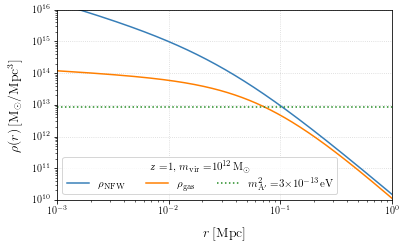

In [26]:
MA = dictKey[maind-10]

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

plt.loglog(rs, ombh2/omch2*nfw_profile, label=r'$\rho_{\rm NFW}$', color=cych[0])  # plasma mass^2 
plt.loglog(rs, ombh2/omch2*gas_profile_1, label=r'$\rho_{\rm gas}$', color=cych[1])  # plasma mass^2 

#plt.axvline(rvirs[zsindex,msindex], ls=':', color=cych[4], label=r'$r_{\rm vir}$')
#plt.axvline(rss, ls=':', color=cych[3], label=r'$r_{\rm s}$')
plt.axhline(MA**2./conv, ls=':', color=cych[2], label=r'$m^2_{\rm A^{\prime}}=$'+fmt(MA)+r'${\rm eV}$')  # mass^2 of dark photon

plt.xlim(1e-3, 1)
plt.ylim(1e10, 1e16)
plt.xlabel(r'$r \, [{\rm Mpc}]$')
plt.ylabel(r'$\rho(r) \, [{\rm M_\odot / Mpc^3}]$')
plt.grid(color='darkgray', alpha=0.5, ls=':')
plt.legend(title=r'$z=$'+fmt(zs[zsindex])+r'$, \, m_{\rm vir}=$'+fmt(ms[msindex]*0.97)+r'$\, \rm M_\odot$', ncol=3)
plt.savefig('./plots/haloscales.pdf')
plt.show()


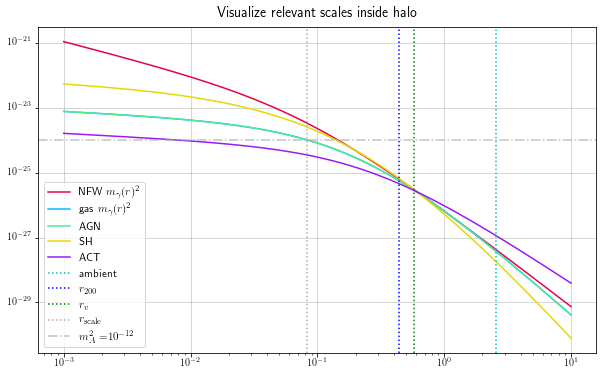

In [19]:
MA = dictKey_NFW[14]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmapsp = ['#e60049', '#0bb4ff', '#50e991', '#e6d800', '#9b19f5', '#ffa300', '#dc0ab4', '#b3d4ff', '#00bfa0']
plt.title('Visualize relevant scales inside halo')
plt.loglog(rs, conv * nfw_profile, label=r'NFW $m_\gamma(r)^2$', color=cmapsp[0])  # plasma mass^2 
plt.loglog(rs, conv * gas_profile, label=r'gas $m_\gamma(r)^2$', color=cmapsp[1])  # plasma mass^2 
plt.loglog(rs, conv * gas_profile_1, label=r'AGN', color=cmapsp[2])  # plasma mass^2 
plt.loglog(rs, conv * gas_profile_2, label=r'SH', color=cmapsp[3])  # plasma mass^2 
plt.loglog(rs, conv * gas_profile_3, label=r'ACT', color=cmapsp[4])  # plasma mass^2 

ramb = rs[np.argmin(np.abs(conv*hcos.rho_matter_z(zs[zsindex])-conv*nfw_profile))]
plt.axvline(ramb, ls=':', color='c', label=r'ambient')  # mass^2 of the A'
plt.axvline(r200critz[zsindex,msindex], ls=':', color='b', label=r'$r_{200}$')  # mass^2 of the A'
plt.axvline(rvir[zsindex,msindex], ls=':', color='g', label=r'$r_v$')

#plt.axvline(rs[np.argmin(np.abs(conv*nfw_profile-MA**2.))], ls='--', color='r', label=r'$m_A^2$')  # mass^2 of the A' with NFW
#plt.axvline(rs[np.argmin(np.abs(conv*gas_profile-MA**2.))], ls='--', color='k', label=r'$m_A^2$')  # mass^2 of the A' with gas profile

plt.axvline(rss, ls=':', color='darkgray', label=r'$r_{\rm scale}$')  # mass^2 of the A' with NFW
plt.axhline(MA**2., ls='-.', color='darkgray', alpha=0.7, label=r'$m_A^2=$'+fmt(MA))  # mass^2 of dark photon

#plt.xlim((min(rs)*0.9, 1))
#plt.ylim((1e-30, 1e-24))
plt.legend()
plt.grid(color='black', alpha=0.2)
plt.savefig('./plots/haloscales.pdf')
plt.show()


In [14]:
def plot_dmdz2(ms, zs, func, ax, lab, cols, count=10, title='No Title'):
    ii=0
    for mi, mm in enumerate(ms):
        if mm in ms[:count]:
            ax[0].plot(zs, func[:,mi], linewidth=1, label=(lab if mm in ms[:count//count] else None), color=cols(ii))
        ii+=1
    ii=0
    for zi, zz in enumerate(zs):
        if zz in zs[:count]:
            ax[1].plot(ms, func[zi,:], linewidth=1, label=(lab if zz in zs[:count//count] else None), color=cols(ii))
        ii+=1

    ax[0].set_xlabel('z')
    ax[1].set_xlabel('m')
    for axx in ax:
        axx.set_yscale('log')
        axx.set_xscale('log')
        axx.set_ylabel(title)
        axx.legend(); axx.grid()
    return ax

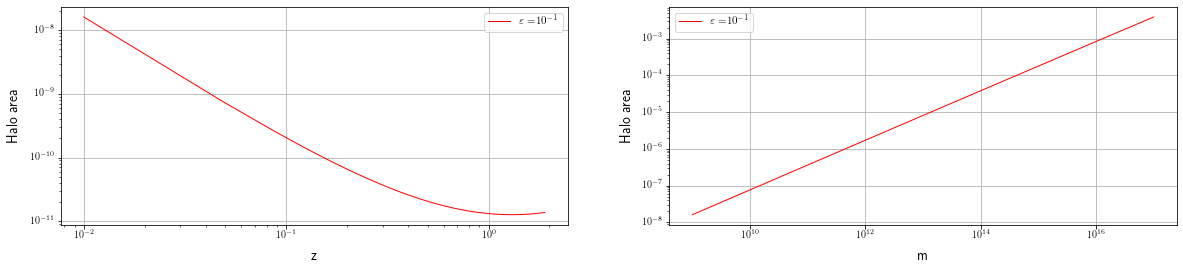

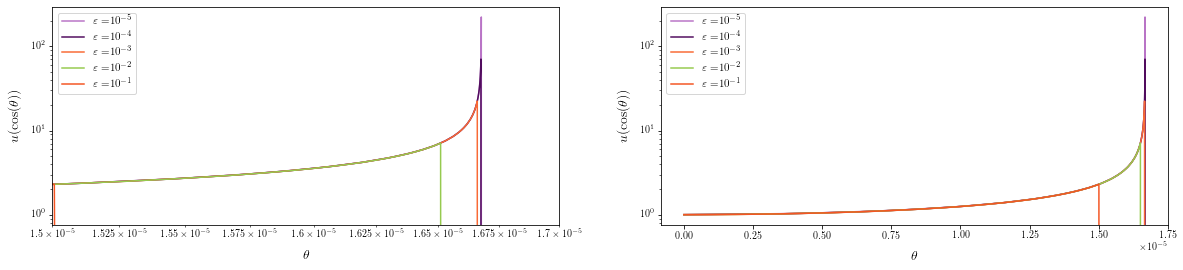

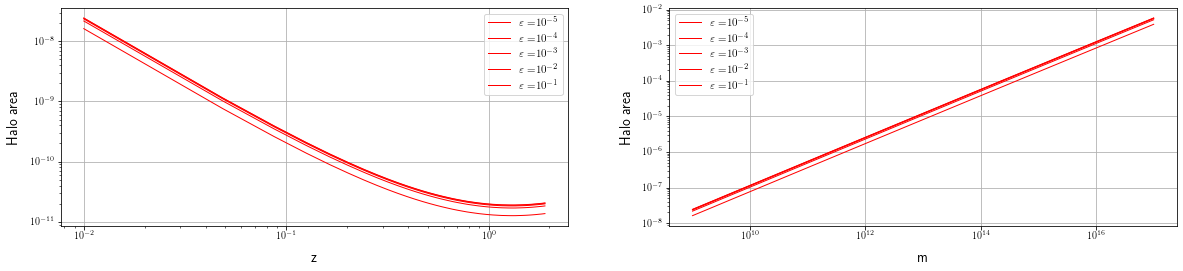

In [8]:
dvols = get_volume_conv(chis, Hz)

testlist = np.geomspace(1e-1, 1e-10, 1)

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
for test in testlist:
    ucosth, angs = get_halo_skyprofile2(zs, chis, rcross, test)
    u00 = get_u00(angs, ucosth)
    ax = plot_dmdz2(ms, zs, u00, ax, cols = get_cmap(13), count=1, title='Halo area', lab = r'$\varepsilon = ${}'.format(fmt(test)))
plt.show()

testlist = np.geomspace(1e-1, 1e-5, 5)

fig1, ax1 = plt.subplots(1, 2, figsize=(20, 4))
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
for test in reversed(testlist):
    
    ucosth, angs = get_halo_skyprofile2(zs, chis, rcross, test)
    ax1[0].plot(angs[:,10,10], ucosth[:,10,10], label = r'$\varepsilon = ${}'.format(fmt(test)))
    ax1[0].set_xlabel(r'$\theta$')
    ax1[0].set_ylabel(r'$u(\cos(\theta))$')
    ax1[0].set_xscale('log')
    ax1[0].set_yscale('log')
    ax1[0].set_xlim((1.5e-5,1.7e-5))
    ax1[0].legend()
    ax1[1].plot(angs[:,10,10], ucosth[:,10,10], label = r'$\varepsilon = ${}'.format(fmt(test)))
    ax1[1].set_xlabel(r'$\theta$')
    ax1[1].set_ylabel(r'$u(\cos(\theta))$')
    ax1[1].legend()
    ax1[1].set_yscale('log')

    u00 = get_u00(angs, ucosth)
    ax = plot_dmdz2(ms, zs, u00, ax, cols = get_cmap(13), count=1, title='Halo area', lab = r'$\varepsilon = ${}'.format(fmt(test)))
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


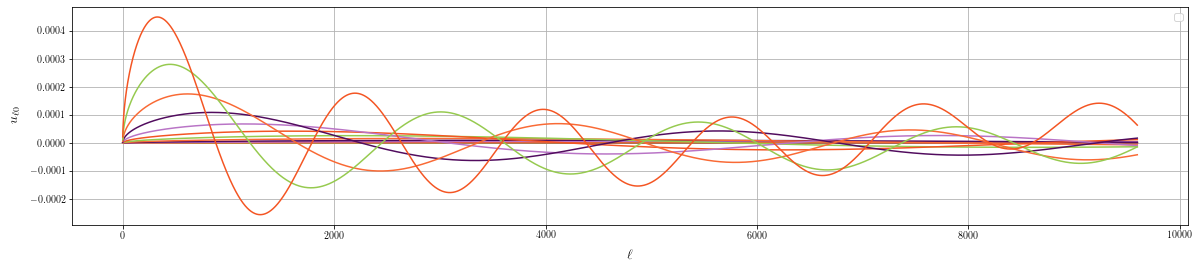

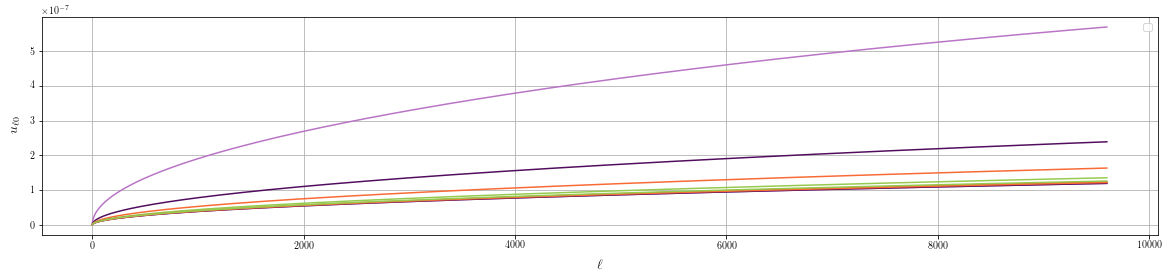

In [9]:
zind = 10
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plt.plot(ells, uell0[:, zind, ::5])#, label=ms[::5])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$u_{\ell 0}$')
plt.legend(); plt.grid()

mind = 20
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plt.plot(ells, uell0[:, 5::5, mind])#, label=zs[5::5])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$u_{\ell 0}$')
plt.legend(); plt.grid()


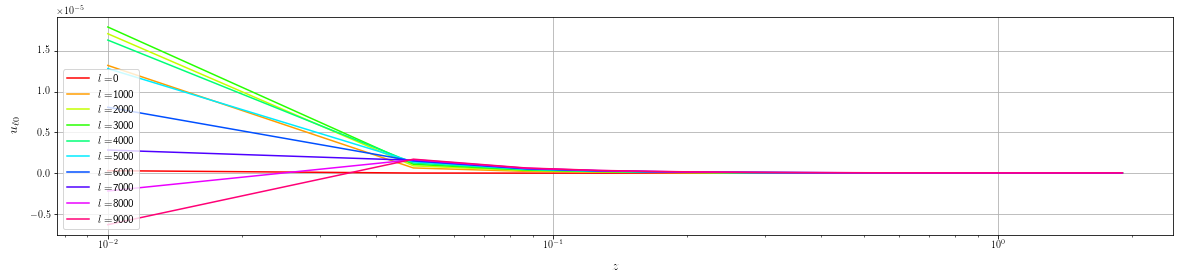

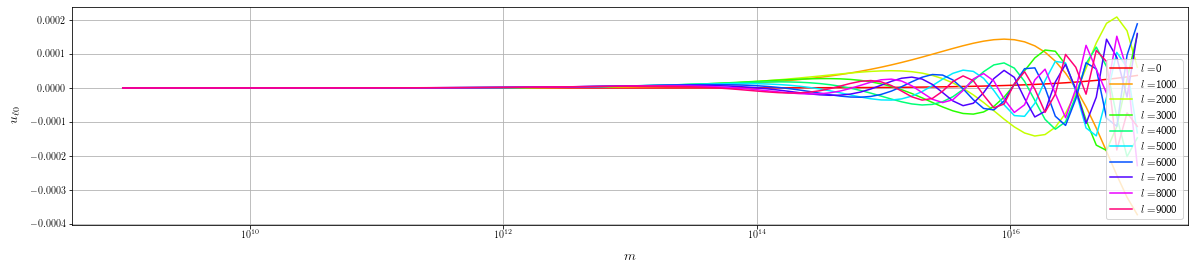

In [10]:
cmap = get_cmap(len(ells)+1)
mind = 10
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
for i, ell in enumerate(ells):
    if ell%1000!=0: continue
    plt.plot(zs, uell0[ell, :, mind], color=cmap(i), label=r'$l=$'+str(ell))
plt.xlabel(r'$z$')
plt.ylabel(r'$u_{\ell 0}$')
plt.xscale('log')
plt.legend(); plt.grid()

cmap = get_cmap(len(ells)+1)
zind = 10
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
for i, ell in enumerate(ells):
    if ell%1000!=0: continue
    plt.plot(ms, uell0[ell, zind, :], color=cmap(i), label=r'$l=$'+str(ell))
plt.xlabel(r'$m$')
plt.ylabel(r'$u_{\ell 0}$')
plt.xscale('log')
plt.legend(); plt.grid()


In [11]:
u00 = get_u00(angs, ucosth)
avtau, dtaudz = get_avtau(zs, ms, nzm, prob, dvols, u00)


N halos: 644064915961.062


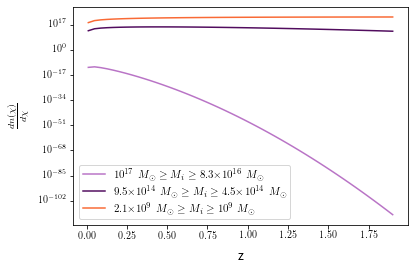

In [12]:
N = np.trapz(dvols * np.trapz(nzm, ms, axis=-1), zs, axis=0); print('N halos:', N)

lab = lambda am, bm: r'{} $M_\odot \geq M_i \geq $ {}'.format(fmt(am), fmt(bm))+r' $M_\odot$'

mspt = ms[-2:]
plt.plot(zs, N*(np.trapz(nzm[:, -2:], mspt, axis=-1)*chis**2./Hz), label=lab(mspt[-1], mspt[0]))

mspt = ms[-30:-25]
plt.plot(zs, N*(np.trapz(nzm[:, -30:-25], mspt, axis=-1)*chis**2./Hz), label=lab(mspt[-1], mspt[0]))

mspt = ms[:5]
plt.plot(zs, N*(np.trapz(nzm[:, :5], mspt, axis=-1)*chis**2./Hz), label=lab(mspt[-1], mspt[0]))

plt.yscale('log')
plt.xlabel('z')
plt.ylabel(r'$\frac{d n(\chi)}{d \chi}$')
plt.legend()
plt.show()

In [13]:
avtau

114353.98739008972

In [14]:
np.trapz(4.*np.pi* chis**2. / Hz * np.trapz(nzm * prob * u00 , ms, axis=-1), zs, axis=0)

114353.98739008972

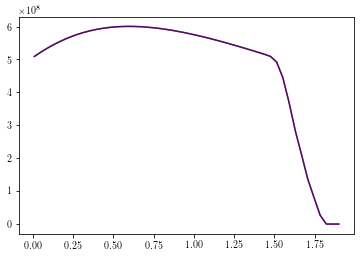

In [15]:
plt.plot(zs, dtaudz/ghztoev(30))
plt.plot(zs, dvols/ghztoev(30) * np.trapz(nzm * prob * u00 , ms, axis=-1))
plt.show()

#### Milky Way

In [16]:
%run 'compute_power_spectra.py'

In [17]:
# Probability to convert within Milky Way
rsMW    = np.geomspace(1e-10,10,1000000)  # halo radius
#csMW    = hcos.concentrationMW(mMWvir); print(csMW)
csMW    = 10.72
HMW     = hcos.h_of_z(0.)
rscaleMW = rMWvir/csMW
print('Compare MW scale radius to Earth\'s orbit radius.', rscaleMW, rEarth)

deltavMW = hcos.deltav(0.)[0]
rhocritzMW = hcos.rho_critical_z(0.)

rcrossMW, probMW = dark_photon_conv_prob_MilkyWay_NFW(mMWvir, rMWvir, csMW, HMW, rEarth, rsMW, MA)
rcrossMW_gas, probMW_gas = dark_photon_conv_prob_MilkyWay_gas(mMWvir, rMWvir, rhocritzMW, deltavMW, csMW, HMW, rEarth, rsMW, MA, name='battagliaAGN')
print(MA, rcrossMW, probMW, avtau)
print(MA, rcrossMW_gas, probMW_gas, avtau)


Compare MW scale radius to Earth's orbit radius. 0.026772388059701495 0.008
1e-12 0.07206524338799071 14425.972334389106 219622.3591674167
1e-12 0.026762484423201706 16809.42939358014 219622.3591674167


In [18]:
DPmasses = np.geomspace(5e-14,1e-11,100)
rcrosstest, probtest = np.empty(len(DPmasses)), np.empty(len(DPmasses))
rcrosstest_gas, probtest_gas = np.empty(len(DPmasses)), np.empty(len(DPmasses))
for mind, mDP in enumerate(DPmasses):
    rcrosstest[mind], probtest[mind] = dark_photon_conv_prob_MilkyWay_NFW(mMWvir, rMWvir, csMW, HMW, rEarth, rsMW, mDP)
    rcrosstest_gas[mind], probtest_gas[mind] = dark_photon_conv_prob_MilkyWay_gas(mMWvir, rMWvir, rhocritzMW, deltavMW, csMW, HMW, rEarth, rsMW, mDP)
mawlimind = np.argwhere(probtest>0)[-1]
MAMWlimit = DPmasses[mawlimind]


In [19]:
print(MAMWlimit)

[1.e-11]


In [20]:
test1 = np.load('./data/MWrscale_massconstraint.npy')
#test2 = np.load('./data/MWmassconstraint.npy')
MAMWlimit = np.load('./data/MWmassconstraint.npy')
print(test1, MAMWlimit)

2.8611838296751096e-12 8.148754173103232e-12


In [21]:
#np.save('./data/MWrscale_massconstraint.npy', MAMWlimit[0])
#np.save('./data/MWmassconstraint.npy', MAMWlimit[0])

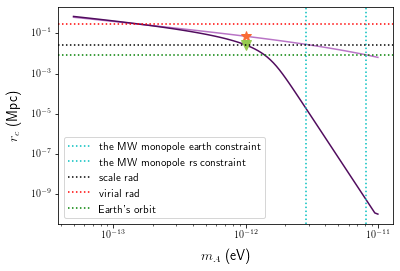

In [22]:
plt.plot(DPmasses, rcrosstest)
plt.plot(DPmasses, rcrosstest_gas)
plt.plot(MA, rcrossMW, marker='*', ms=10)
plt.plot(MA, rcrossMW_gas, marker='v', ms=10)
#plt.plot(DPmasses[probtest>=0], probtest[probtest>=0], label='P conv')
#plt.plot(DPmasses[probtest_gas>=0], probtest_gas[probtest_gas>=0], label='P conv gas')

plt.axvline(MAMWlimit, color='c', ls=':', label='the MW monopole earth constraint')
plt.axvline(test1, color='c', ls=':', label='the MW monopole rs constraint')

plt.axhline(rscaleMW, color='k', ls=':', label='scale rad')
plt.axhline(rMWvir, color='r', ls=':', label='virial rad')
plt.axhline(rEarth, color='g', ls=':', label='Earth\'s orbit')

plt.xlabel(r'$m_A$ (eV)'); plt.ylabel(r'$r_c$ (Mpc)')
plt.xscale('log'); plt.yscale('log')
plt.legend(); plt.show()


In [24]:
delta_rhos1 = rhocritzMW*deltavMW
delta_rhos2 = 200.*rhocritzMW
m200critzMW = hm.mdelta_from_mdelta_unvectorized(mMWvir, csMW, delta_rhos1, delta_rhos2)
r200critzMW = hm.R_from_M(m200critzMW, rhocritzMW, delta=200.)
    
gas_profile_MW = get_gas_profile(rsMW, 0., m200critzMW, r200critzMW, rhocritzMW, name='battagliaAGN')


No handles with labels found to put in legend.


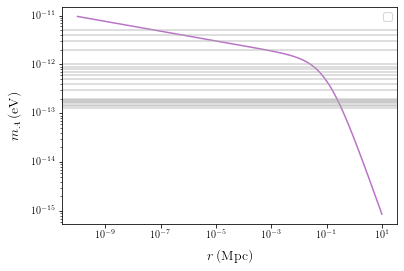

In [50]:
plt.plot(rsMW, np.abs(conv*gas_profile_MW)**0.5)
for MA in dictKey_gas:
    plt.axhline(MA, alpha=0.5, color='darkgray')
    idx  = np.argmin(np.abs(conv*gas_profile - MA**2.))
    #rcross = rsMW[idx]
    #dmdr = np.abs(conv*get_deriv_gas_profile(rsMW, 0., m200critzMW, r200critzMW, rhocritzMW, name='battagliaAGN'))

drhodr = get_deriv_gas_profile(rsMW, 0., m200critzMW, r200critzMW, rhocritzMW, name='battagliaAGN')
#plt.plot(rsMW, 1./np.abs(conv*drhodr), color='g')

rss = rMWvir/csMW
rfr = rsMW/rss
nfw_rhoscsales = hm.rhoscale_nfw(mMWvir, rMWvir, csMW)
dmdr = np.abs(conv*(nfw_rhoscsales/rss)*(1.+3.*rfr)/(rfr)**2./(1.+rfr)**3.)
#plt.plot(rsMW, 1./dmdr, color='c')


plt.ylabel(r'$m_A \, ({\rm eV})$'); plt.xlabel(r'$r \, ({\rm Mpc})$')
plt.xscale('log'); plt.yscale('log')
plt.legend(); plt.show()

In [191]:
%run 'compute_power_spectra.py'

In [192]:
ms   = np.geomspace(mMin,mMax,nMs)          # masses
zs   = np.linspace(zMin,zMax,nZs)           # redshifts
print(MA, rMin)
#rs   = np.geomspace(rMin,rMax,100000)        # halo radius
rs   = np.asarray([0]+np.geomspace(1e-18,rMax,100000).tolist())
ks   = np.geomspace(1e-4,1e3,1001)          # wavenumbers


1e-12 0.001


In [172]:
rcrossgas = get_rcross_per_halo_gas(zs, ms, rs, rvir, rhocritz, deltav, cs, mDP, name='battagliaAGN')


/home/dpirvu/DarkPhoton/compute_power_spectra.py:96: RuntimeWarning: divide by zero encountered in power
  rhogas = rho * (x**gamma) * ((1. + x**alpha)**expo)


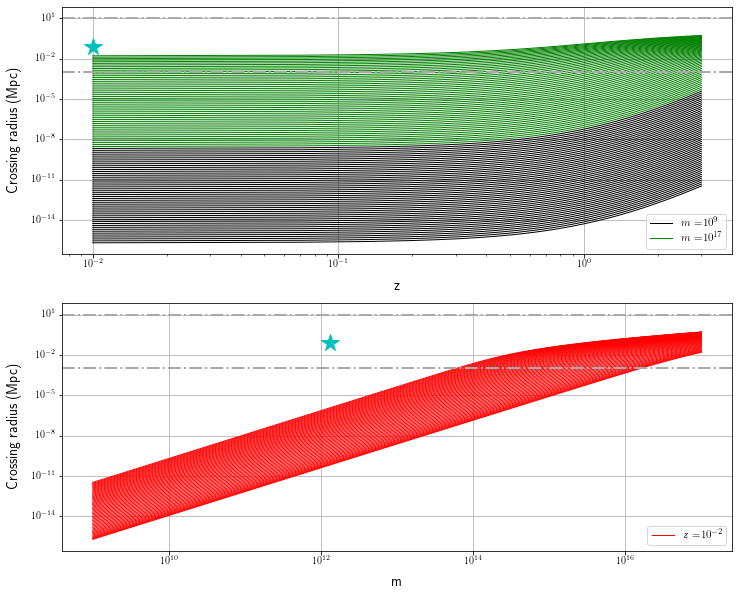

In [175]:
ax1 = plot_dmdz(ms, zs, rcrossgas, count=50, title='Crossing radius (Mpc)')
ax1[0].plot(zs[0],  rcrossMW, label=(f'MW'), color='c', marker='*', ms=18)
ax1[1].plot(mMWvir, rcrossMW, label=(f'MW'), color='c', marker='*', ms=18)

ax1[0].axhline(rMin, color='darkgray', ls='-.', linewidth=2)
ax1[0].axhline(rMax, color='darkgray', ls='-.', linewidth=2)
ax1[1].axhline(rMin, color='darkgray', ls='-.', linewidth=2)
ax1[1].axhline(rMax, color='darkgray', ls='-.', linewidth=2)
plt.show()


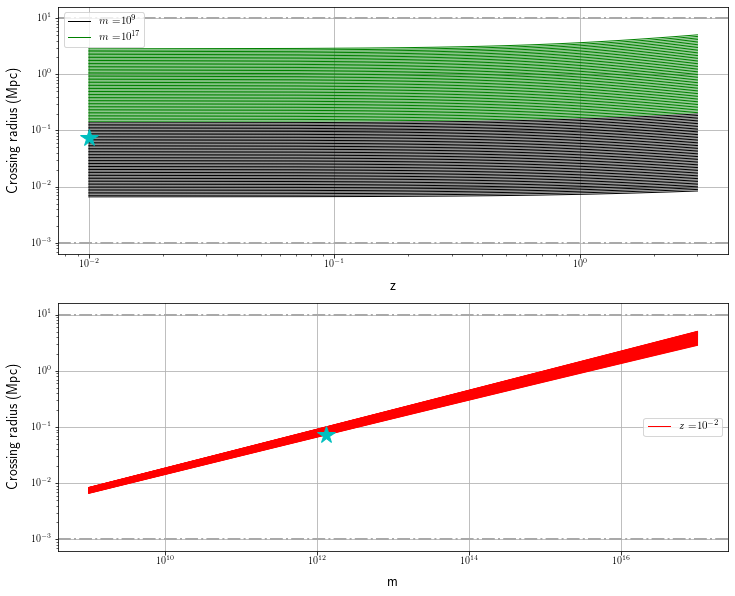

In [174]:
ax1 = plot_dmdz(ms, zs, rcross, count=50, title='Crossing radius (Mpc)')
ax1[0].plot(zs[0],  rcrossMW, label=(f'MW'), color='c', marker='*', ms=18)
ax1[1].plot(mMWvir, rcrossMW, label=(f'MW'), color='c', marker='*', ms=18)

ax1[0].axhline(rMin, color='darkgray', ls='-.', linewidth=2)
ax1[0].axhline(rMax, color='darkgray', ls='-.', linewidth=2)
ax1[1].axhline(rMin, color='darkgray', ls='-.', linewidth=2)
ax1[1].axhline(rMax, color='darkgray', ls='-.', linewidth=2)
plt.show()


In [210]:
%run 'compute_power_spectra.py'

In [211]:
print(np.shape(rcrossgas))

(50, 100)


In [212]:
prob_gas = dark_photon_conv_prob_gas(zs, ms, rs, rvir, rhocritz, deltav, cs, MA, rcrossgas, name='battagliaAGN')

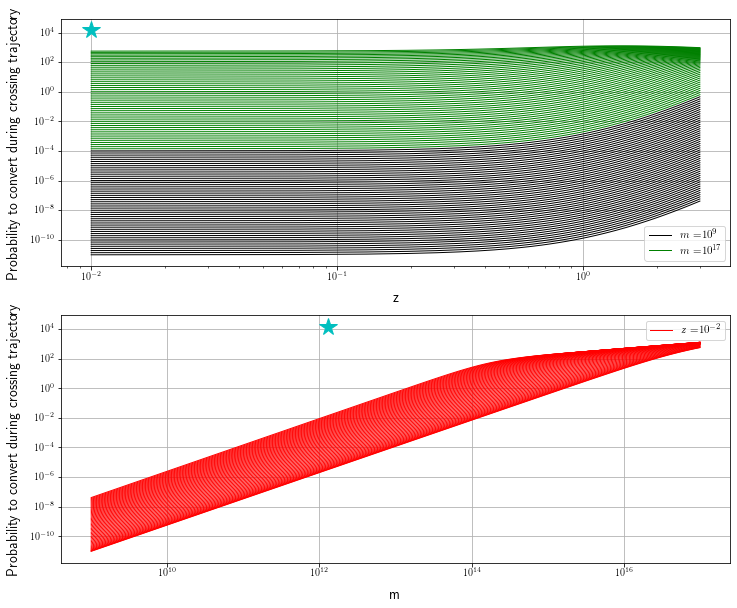

In [213]:
ax = plot_dmdz(ms, zs, prob_gas, count=50, title='Probability to convert during crossing trajectory')

ax[0].plot(zs[0],  probMW, label=(f'MW'), color='c', marker='*', ms=18)
ax[1].plot(mMWvir, probMW, label=(f'MW'), color='c', marker='*', ms=18)
plt.show()

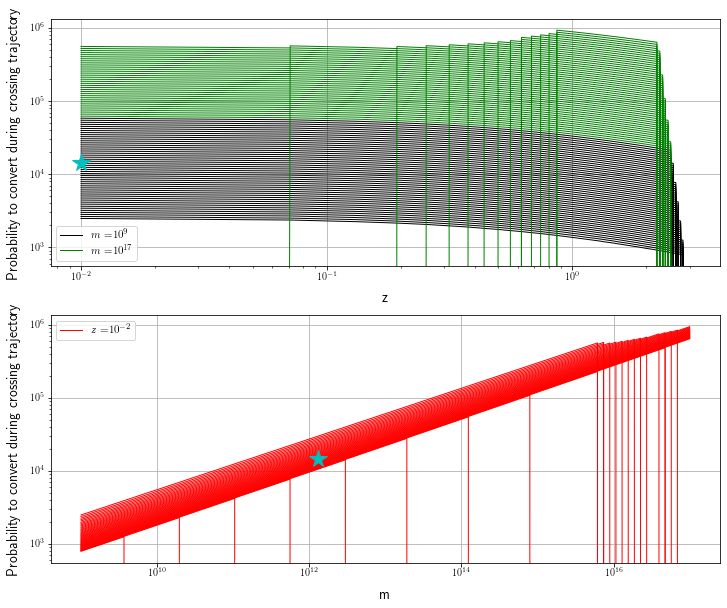

In [214]:
ax = plot_dmdz(ms, zs, prob, count=50, title='Probability to convert during crossing trajectory')

ax[0].plot(zs[0],  probMW, label=(f'MW'), color='c', marker='*', ms=18)
ax[1].plot(mMWvir, probMW, label=(f'MW'), color='c', marker='*', ms=18)
plt.show()


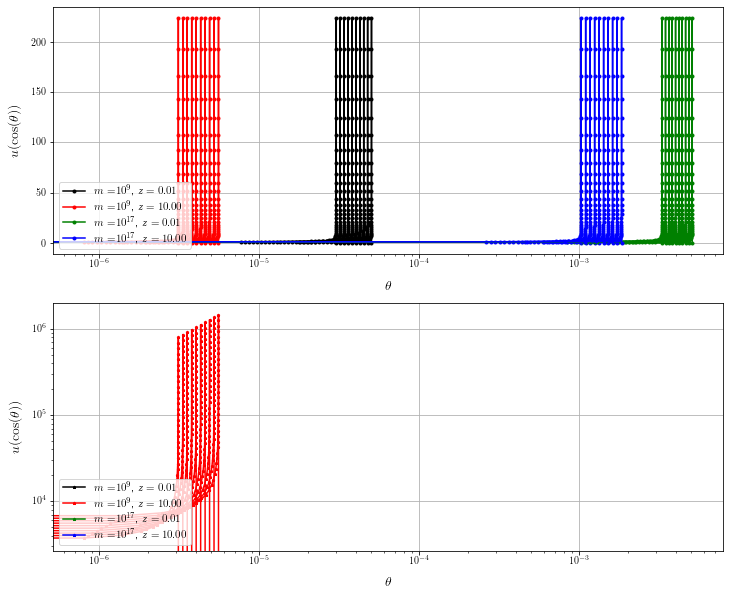

In [33]:
ucosth, angs = get_halo_skyprofile(zs, chis, rcross)

ax = plot_ucosth(ms, zs, angs, ucosth, prob, count=10, title='Crossing radius (Mpc)')
ax[0].set_yscale('linear')
#[aax.set_xscale('linear') for aax in ax]
[aax.legend(loc=3) for aax in ax]; plt.show()


### Power spectra

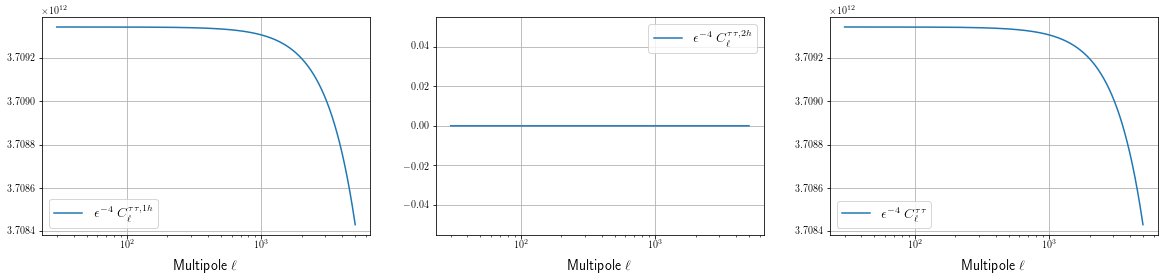

In [25]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
label_list = [r'$C_\ell^{\tau\tau, 1h}$',r'$C_\ell^{\tau\tau, 2h}$',r'$C_\ell^{\tau\tau}$']

mm = 30
mmm = 5000
ax[0].plot(ells[mm:mmm], Cell1H[mm:mmm], label=r'$\epsilon^{-4}$ '+label_list[0])
ax[1].plot(ells[mm:mmm], Cell2H[mm:mmm], label=r'$\epsilon^{-4}$ '+label_list[1])
ax[2].plot(ells[mm:mmm], CellTauTau[mm:mmm], label=r'$\epsilon^{-4}$ '+label_list[2])

for aa, axx in enumerate(ax):
    axx.set_xlabel(r'Multipole $\ell$')
    axx.set_xscale('log')
    axx.legend(); axx.grid()
plt.savefig(dirplots+'celltautau_terms_total.pdf'); plt.show()

NameError: name 'CMBDP' is not defined

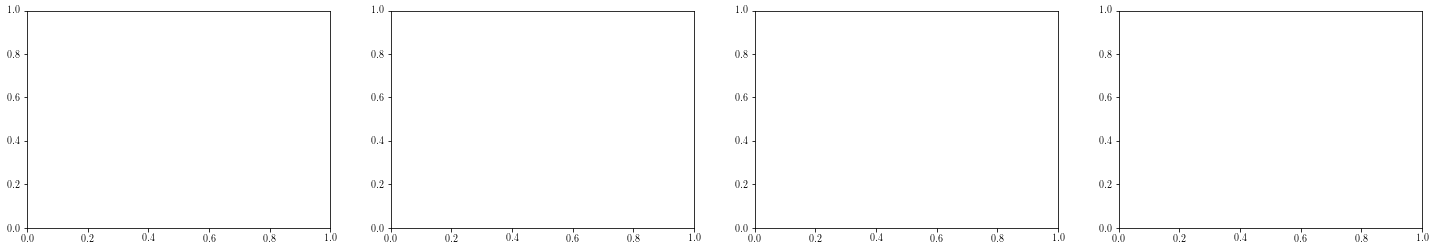

In [31]:
mm = 30
mmm = 5000

#preqs = ells[mm:mmm]*(ells[mm:mmm]+1)/2./np.pi
preqs = 1.

ylabel_list = [r'$\sum C_{\ell}^{\tau\tau} C_{\ell}^{TT, {\rm rec}} W^2_{3j}$',r'$\sum C_{\ell}^{\tau\tau} C_{\ell}^{EE, {\rm rec}} W^2_{3j}$',\
               r'$\sum C_{\ell}^{\tau\tau} C_{\ell}^{BB, {\rm rec}} W^2_{3j}$',r'$\sum C_{\ell}^{\tau\tau} C_{\ell}^{TE, {\rm rec}} W^2_{3j}$']

fig, ax = plt.subplots(1,4, figsize = (25,4))
for ii in range(len(CMBDP)):
    ax[ii].plot(ells[mm:mmm], CMBDP[ii, mm:mmm], ls='-' , label=r'scr $\ell_{max}=$'+str(ellMax))
    ax[ii].plot(ells[mm:mmm], CMBDP2[ii, mm:mmm], ls=':' , label=r'scr $\ell_{max}=$'+str(ellMax))

ax[0].set_yscale('log')
for ai, ax in enumerate(ax):
    ax.set_xlabel(r'Multipole $\ell$')
    ax.set_ylabel(ylabel_list[ai])
    ax.legend(); ax.grid()
plt.show()

Using value epsilon= 3e-05


/home/dpirvu/DarkPhoton/compute_power_spectra.py:219: RuntimeWarning: divide by zero encountered in power
  NellTT[:, frq] = deltaT[frq] * Beam * (1. + (ells/lknee[frq])**aknee[frq] )


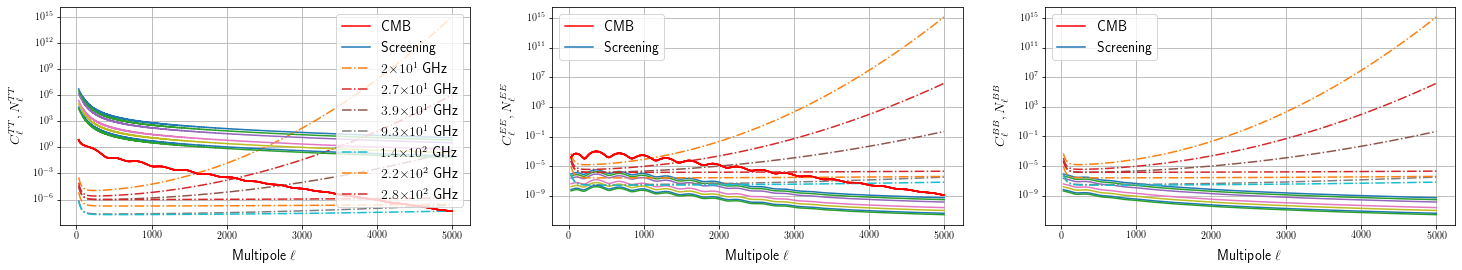

In [48]:
epsilon = 3.e-5
print('Using value epsilon=', epsilon)

# Plot noise + CMB signal for each experiment and frequency channel
for experiment in [CMBS4]:#[Planck, CMBS4, CMBHD]:
    Nell  = noise(ells, experiment)
    freqs = experiment['freqsGHz']

    fig, ax = plt.subplots(1,3, figsize = (25,4))
    for ii in range(3):
        for jj in range(len(freqs)):
            ax[ii].plot(ells[mm:mmm], preqs*(unlenCMB[mm:mmm, ii]), label=('CMB' if jj==0 else None), color='r')
            ax[ii].plot(ells[mm:mmm], preqs*(epsilon**4./freqs[jj]**2. * CMBDP[ii, mm:mmm]), label=('Screening' if jj==0 else None))
            ax[ii].plot(ells[mm:mmm], preqs*(Nell[ii, mm:mmm, jj]), ls='-.', label=('{} GHz'.format(fmt(freqs[jj])) if ii==0 else None))

    title_list = np.asarray([r'$C_\ell^{TT}, N_\ell^{TT}$', r'$C_\ell^{EE}, N_\ell^{EE}$', r'$C_\ell^{BB}, N_\ell^{BB}$'])
    for ai, ax in enumerate(ax.reshape(-1)):
        ax.set_yscale('log')
        ax.set_xlabel(r'Multipole $\ell$')
        ax.set_ylabel(title_list[ai])
        ax.legend(); ax.grid()
    plt.show()

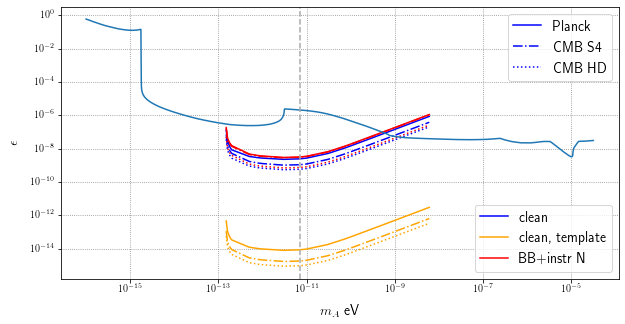

In [29]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
cols = cycle(['b', 'orange', 'r', 'forestgreen', 'purple', 'yellow']) # number of forecasts
lsss = cycle(['-', '-.', ':']) # number of experiments
expname = ['Planck', 'CMB S4', 'CMB HD']
estimator = ['clean', 'clean, template', 'BB+instr N']

jhdata = np.genfromtxt('DPlimits.txt')

secondary_lines, secondary_labels = [], []
for jk in range(len(estimator)):
    col = next(cols)

    for jp in range(len(expname)):
        ls = next(lsss)

        l1, = plt.plot(dictKey_NFW, sigmaEpsilonList[:, jp, jk], color=col, ls=ls, label=(expname[jp] if jk==0 else None))
        if jp==0:
            secondary_labels.append(estimator[jk])
            secondary_lines.append(l1)

plt.plot(jhdata[:-2500,0], jhdata[:-2500,1])
plt.axvline(MAMWlimit, ls='--', color='darkgray')
ax.add_artist(plt.legend(secondary_lines, secondary_labels, loc=4))
plt.xlabel(r'$m_{A} $ eV')
plt.ylabel(r'$\epsilon$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc=1)
plt.grid(ls=':', color='gray')
plt.savefig('./plots/contours.pdf', rasterize=True)
plt.show()
